# GrabCutを使った前景領域抽出

GrabCutアルゴリズムはイギリスのMicrosoft Research Cambridgeの研究者だったCarsten Rother, Vladimir Kolmogorov, Andrew Blakeらの論文   “GrabCut”: interactive foreground extraction using iterated graph cuts で提案されたアルゴリズムです。

まず、初期値として前景領域を矩形で選択する(前景物体は矩形からはみ出さないようにすること)。  
与えられた初期値を基に、GrabCutは処理を繰り返しながら前景の領域分割を行う。  
しかし、前景が背景に含まれたり、その逆にといったように分割がうまくいかない時もある。
そのような時は、結果をよくするためにユーザ入力が必要になります。領域分割に失敗した場所に線を描いてください。この線が何を意味するかと言うと， “背景(前景)に識別されたこの領域は前景(背景)だよ，次の繰り返し計算では修正してね” とプログラムに伝えるためのユーザ入力になります。ユーザ入力を加えた次の繰り返し計算の結果はより良いものになります．

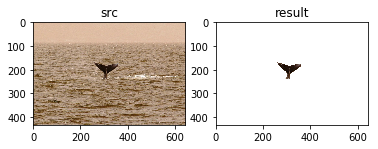

True

In [94]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

fname = 'IMGP4209.JPG'
img = cv2.imread(fname)

h, w = img.shape[:2]
rect = (200, 130, 200, 220)

mask = np.zeros(img.shape[:2], np.uint8) # マスク用領域
bgModel = np.zeros((1, 65), np.float64) # 背景GMMモデル
fgModel = np.zeros((1, 65), np.float64) # 前景GMMモデル
cv2.grabCut(img, mask, rect, bgModel, fgModel, 6, cv2.GC_INIT_WITH_RECT) # イテレーション回数5
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype(np.uint8) # maskの値が1の部分のみ残して0クリア
out = img * mask2[:, :, np.newaxis] # カラーチャンネルの分だけbroadcastしつつ掛け算、結果として1の領域のみ残す

# 背景を透過処理
img_bgr = cv2.split(out)
mask2 = mask2*255
img_alpha = cv2.merge(img_bgr+[mask2])
#img_alpha = out

plt.subplot(1, 2, 1) # plt.subplot(行数, 列数, 何番目のプロットか)
plt.imshow(img),plt.title('src')
plt.subplot(1, 2, 2) # plt.subplot(行数, 列数, 何番目のプロットか)
plt.imshow(img_alpha),plt.title('result'),plt.show()
cv2.imwrite("tmp.png",img_alpha)
cv2.imwrite('out.jpg', out)

## 輪郭抽出

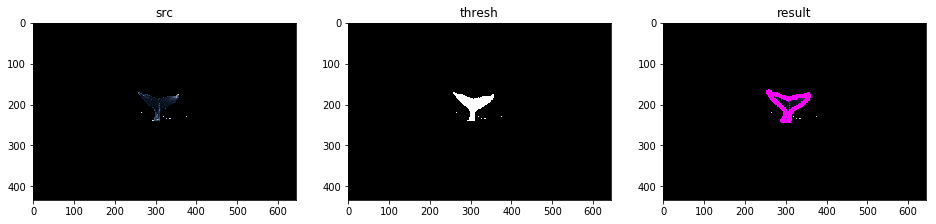

(<matplotlib.axes._subplots.AxesSubplot at 0x15fee7c89b0>,
 Text(0.5,1,'result'),
 None)

In [40]:
hoge = cv2.imread('tmp.png')
test_img = np.copy(hoge)

gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# binarize image
retval, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY) # グレースケールにしなくても2値化処理はできる

#bw = cv2.bitwise_not(bw) # コインを取り出すために2値画像を反転させる

#  Find Contours
imgEdge,contours,hierarchy = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

contours.sort(key=cv2.contourArea, reverse=True)

if len(contours[0]) > 0:
    contour = contours[0]

    # 輪郭の近似
    epsilon = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,
                              0.003*epsilon,  # 近似の具合
                              True)
    cv2.drawContours(test_img, [approx], -1, (255, 0, 255), 10)

plt.subplots(figsize=(16, 12))
plt.subplot(1, 3, 1),plt.imshow(cv2.cvtColor(hoge, cv2.COLOR_BGR2RGB)), plt.title('src')
plt.subplot(1, 3, 2),plt.imshow(cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)), plt.title('thresh')
plt.subplot(1, 3, 3), plt.title('result'), plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)), plt.show() 

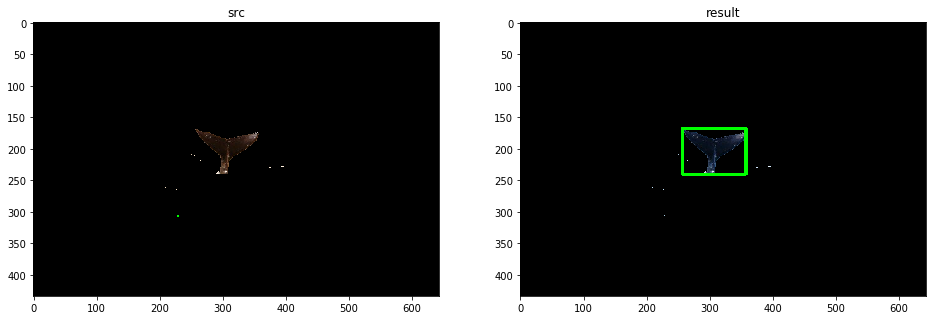

(<matplotlib.axes._subplots.AxesSubplot at 0x15feea69908>,
 Text(0.5,1,'result'),
 None)

In [44]:
#画像読込
in_img1 = cv2.imread("tmp.png", -1) 

#グレイ画像へ変換
gray_img = cv2.cvtColor(in_img1, cv2.COLOR_BGR2GRAY)
#２値化
ret,thresh = cv2.threshold(gray_img, 0, 255,0)

#輪郭抽出
image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# find contours of large enough area
min_area = 60
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# create copy of image to draw bounding boxes
bounding_img = np.copy(in_img1)

# for each contour find bounding box and draw rectangle
for contour in large_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(bounding_img, (x, y), (x + w, y + h), (0, 255, 0), 3)

#OpenCVがBGRなのでRGBに変換
disp_out_img1 = cv2.cvtColor(bounding_img, cv2.COLOR_BGR2RGB)

#画像表示
plt.subplots(figsize=(16, 12))
plt.subplot(1, 2, 1), plt.title('src'), plt.imshow(img)
plt.subplot(1, 2, 2), plt.title('result'), plt.imshow(disp_out_img1), plt.show()


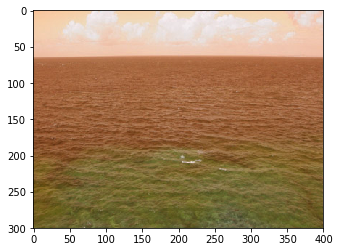

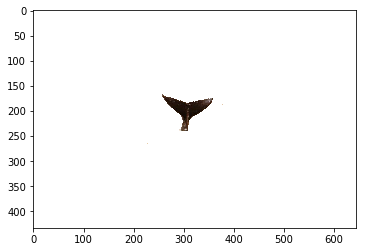

error: OpenCV(3.4.1) D:\Build\OpenCV\opencv-3.4.1\modules\core\src\arithm.cpp:241: error: (-215) (mtype == 0 || mtype == 1) && _mask.sameSize(*psrc1) in function cv::binary_op


In [108]:
img1 = cv2.imread('sea.jpg')  # 背景（下敷きになる画像）
img2 = cv2.imread('tmp.png', -1)  # 前景（乗せたい画像）

rows,cols,channels = img2.shape
roi = img1[0:rows, 0:cols ]

plt.imshow(img1),plt.show()
plt.imshow(img2),plt.show()

img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

dst = cv2.add(img1_bg,img2_fg)
img1[0:rows, 0:cols ] = dst

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.subplot(1, 2, 1) # plt.subplot(行数, 列数, 何番目のプロットか)
plt.imshow(src)

cv2.imwrite("tmpp.png",img1)
plt.subplot(1, 2, 2) # plt.subplot(行数, 列数, 何番目のプロットか)
plt.imshow(img1),plt.show()

## アフィン変換による画像合成

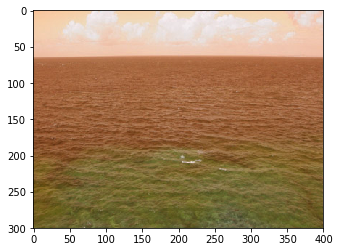

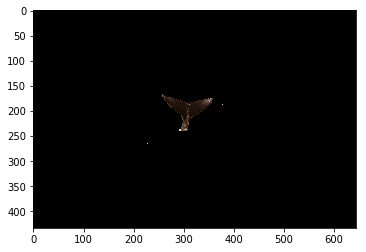

300
400


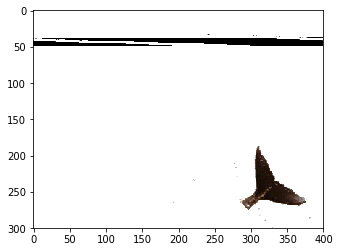

True

In [119]:
dst_img = cv2.imread('sea.jpg')  # 背景（下敷きになる画像）
src_img = cv2.imread('tmp.png')  # 前景（重ねたい画像）

# dst_img = cv2.imread('messi5.jpg')
# src_img = cv2.imread('mini-logo.png')

plt.imshow(dst_img),plt.show()
plt.imshow(src_img),plt.show()

# 画像読み込み
img_src = cv2.imread("tmp.png", -1)

# 画像サイズの取得(横, 縦)
size = tuple([img_src.shape[1], img_src.shape[0]])

# 画像の中心位置(x, y)
center = tuple([int(size[0]/2), int(size[1]/2)])

# 回転させたい角度（正の値は反時計回り）
angle = -45.0

# 拡大比率
scale = 1.0

# 回転変換行列の算出
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

# アフィン変換
img_rot = cv2.warpAffine(img_src, rotation_matrix, size, flags=cv2.INTER_CUBIC)


#//前景画像の変形行列
#cv::Mat mat = (cv::Mat_<double>(2,3)<<1.0, 0.0, tx, 0.0, 1.0, ty);
M = np.float32([[1, 0, 0], [0, 1, 50]])
rows, cols = dst_img.shape[:2]
print(str(rows))
print(str(cols))
dst = cv2.warpAffine(img_rot, M, (cols, rows), dst_img, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)

# //アフィン変換の実行borderModepAffine(smallImg, dstImg, mat, dstImg.size(), CV_INTER_LINEAR, cv::BORDER_TRANSPARENT);
plt.imshow(dst),plt.show()
cv2.imwrite('hogehoge.png', dst)

In [96]:
# 画像読み込み(alphaチャンネル有り)
src_mat = cv2.imread("tmp.png", cv2.IMREAD_UNCHANGED)
print(src_mat.shape) # 32,32,4

# 画像サイズの取得(横, 縦)
size = tuple([src_mat.shape[1], src_mat.shape[0]])

# dst 画像用意
dst_mat = np.zeros((size[1], size[0], 4), np.uint8)

# 画像の中心位置(x, y)
center = tuple([int(size[0]/2), int(size[1]/2)])

# 回転させたい角度（正の値は反時計回り）
angle = -45.0

# 拡大比率
scale = 1.0

# 回転変換行列の算出
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

# アフィン変換
img_dst = cv2.warpAffine(src_mat, rotation_matrix, size, dst_mat,
                         flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_TRANSPARENT)

# 表示
cv2.imwrite("dst.png", img_dst)

(434, 644, 4)


True

In [118]:
# 画像読み込み
img_src = cv2.imread("tmp.png", -1)

cv2.imshow("Show ROTATION Image", img_src)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 画像サイズの取得(横, 縦)
size = tuple([img_src.shape[1], img_src.shape[0]])

# 画像の中心位置(x, y)
center = tuple([int(size[0]/2), int(size[1]/2)])

# 回転させたい角度（正の値は反時計回り）
angle = -45.0

# 拡大比率
scale = 1.0

# 回転変換行列の算出
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

# アフィン変換
img_rot = cv2.warpAffine(img_src, rotation_matrix, size, flags=cv2.INTER_CUBIC)

# 表示
cv2.imshow("Show ROTATION Image", img_rot)
cv2.waitKey(0)
cv2.destroyAllWindows()